In [1]:
import scipy as sp
import pylab as plt
from scipy.integrate import odeint

plt.style.use('ggplot')

In [2]:
# full Hodgkin-Huxley model
# membrane capacitance (uF/cm^2)
C_m = 1.0

# constants for Na gate
g_Na = 120.0
V_Na = 115.0

# constants for K gate
g_K = 36.0
V_K = -12.0

# constants for leak gate
g_L = 0.3
V_L = 10.613

# time we'll be integrating over. We'll be operating over 500 ms with a step size of 0.01.
t = sp.arange(0.0, 500.0, 0.01)

# functions for computing current through membranes
def i_Na(V, m, h):
    return g_Na * m ** 3 * h * (V - V_Na)


def i_K(V, n):
    return g_K * n ** 4 * (V - V_K)


def i_L(V):
    return g_L * (V - V_L)


# functions for rate constants of ion channels
def alpha_n(V):
    return 0.01 * (10.0 - V) / (sp.exp((10.0 - V) / 10.0) - 1.0)


def beta_n(V):
    return 0.125 * sp.exp(-V / 80.0)


def alpha_m(V):
    return 0.1 * (25.0 - V) / (sp.exp((25.0 - V) / 10.0) - 1.0)


def beta_m(V):
    return 4.0 * sp.exp(-V / 18.0)


def alpha_h(V):
    return 0.07 * sp.exp(-V / 20.0)


def beta_h(V):
    return 1.0 / (1.0 + sp.exp((30 - V) / 10.0))


# input injection function
def inject_I(t):
    # tuples dictating fluctuations in external current upon injection in given time frames (basially where spikes will occur) =>
    step1 = {"t": 0, "V": 10}  # step up 10 uA/cm^2 @ t=0
    step2 = {"t": 100, "V": -10}  # step down 10 uA/cm^2 @ t=100
    step3 = {"t": 200, "V": 20}  # step up 20 uA/cm^2 @t=200
    step4 = {"t": 300, "V": 80}  # step up 80 uA/cm^2 @ t=300
    step5 = {"t": 400, "V": -100}  # step down 100 uA/cm^2 @ t=400

    return (
        step1["V"] * (t > step1["t"])
        + step2["V"] * (t > step2["t"])
        + step3["V"] * (t > step3["t"])
        + step4["V"] * (t > step4["t"])
        + step5["V"] * (t > step5["t"])
    )


# computes derivatives of activation variables
def compute_derivs(X, t):
    V, m, h, n = X
    dVdt = (inject_I(t) - i_Na(V, m, h) - i_K(V, n) - i_L(V)) / C_m
    dmdt = alpha_m(V) * (1.0 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1.0 - h) - beta_h(V) * h
    dndt = alpha_n(V) * (1.0 - n) - beta_n(V) * n
    return dVdt, dmdt, dhdt, dndt


Text(0.5, 0, 'Time (ms)')

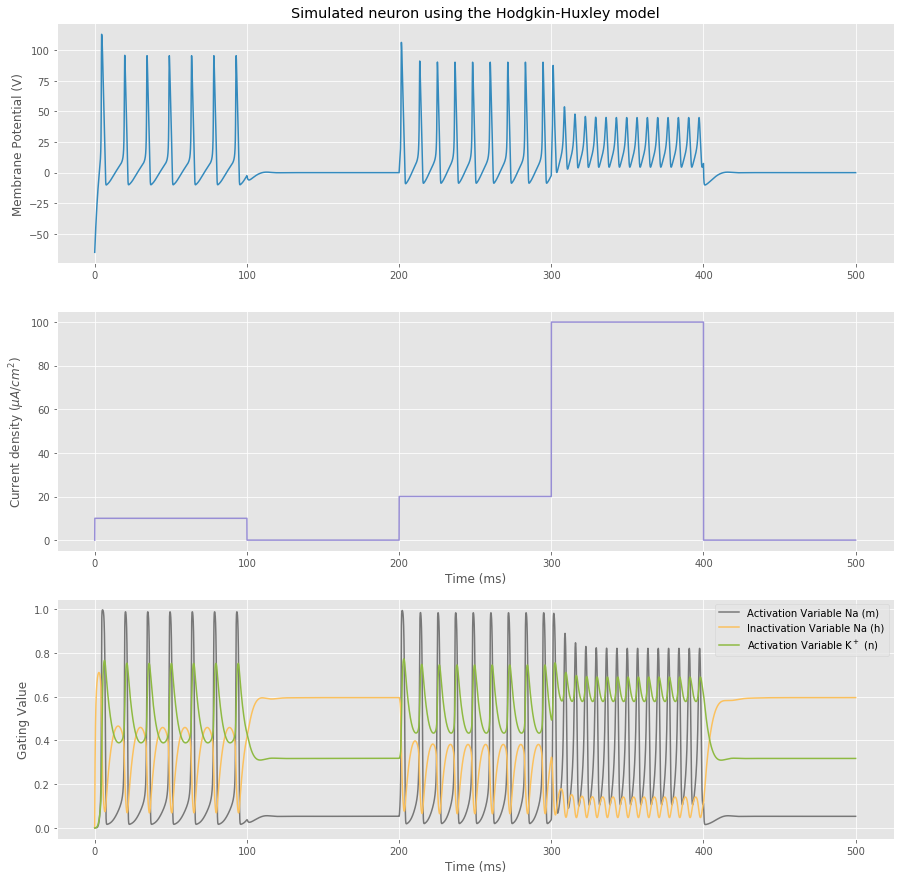

In [21]:
# plotting Hodgkin-Huxley model simulation
X = odeint(compute_derivs, [-65.0, 0.0, 0.0, 0.0], t)
V = X[:, 0]
m = X[:,1]
h = X[:,2]
n = X[:,3]

plt.figure(figsize=(15, 15))
plt.subplot(3, 1, 1)
plt.title("Simulated neuron using the Hodgkin-Huxley model")
plt.plot(t, V, "C1", label="Membrane Potential")
plt.ylabel("Membrane Potential (V)")

plt.subplot(3, 1, 2)
plt.plot(t, [inject_I(x) for x in t], "C2", label="Input Current")
plt.ylabel("Current density ($µA/cm^2$)")
plt.xlabel("Time (ms)")

plt.subplot(3, 1, 3)
plt.plot(t, m, "C3", label="Activation Variable Na (m)")
plt.plot(t, h, "C4", label="Inactivation Variable Na (h)")
plt.plot(t, n, "C5", label="Activation Variable K$^+$ (n)")
plt.legend(loc="upper right")
plt.ylabel("Gating Value")
plt.xlabel("Time (ms)")
